# This notebook is under construction. 

- In this notebook a rather simple 1-D CNN is trained and tested on H-alpha diagnostics. 
- Later this 1-D CNN may be used as a supplementary model for the ensembled RIS1xRIS2 resp. RIS1xRIS1 model, which have poor performance in distinguishing H-modes from ELMs.


- Functions written here will migrate to `confinement_mode_classifier.py` once tested

In [3]:
import os
from pathlib import Path
import re
import time 
from datetime import datetime

import torch
from tqdm import tqdm
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import pandas as pd

import alt_models as am

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
path = Path(os.getcwd())

In [4]:
#What signal to use
signal_name = 'divlp' # mc - Minkowski coil, divlp - divertor Langmuir probe
architecture = 'InceptionTime'
signal_window = 320
batch_size = 512
num_workers = 8
num_epochs = 12
learning_rate_min = 0.001
learning_rate_max = 0.01
comment_for_model_name = architecture + '_on_' + signal_name  + str(signal_window)

In [6]:
shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_ris = shot_usage[shot_usage['used_for_alt']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']

shot_df, test_df, val_df, train_df = am.split_df(path, shot_numbers, shots_for_testing, shots_for_validation, use_ELMS=True)


In [7]:
train_dataloader = am.get_dloader(train_df, batch_size=batch_size, 
                               balance_data=True, shuffle=False, 
                               signal_window=signal_window,
                               signal_name=signal_name,
                               num_workers=num_workers)

val_dataloader = am.get_dloader(val_df, batch_size=batch_size, 
                             balance_data=True, shuffle=False, 
                             signal_window=signal_window,
                             signal_name=signal_name,
                             num_workers=num_workers)

test_dataloader = am.get_dloader(test_df, batch_size=batch_size, 
                              balance_data=False, shuffle=False, 
                              signal_window=signal_window,
                              signal_name=signal_name,
                              num_workers=num_workers)

dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

In [8]:
timestamp =  datetime.fromtimestamp(time.time()).strftime("%y-%m-%d, %H-%M-%S ") + comment_for_model_name

writer = SummaryWriter(f'runs/{timestamp}')
model_path = Path(f'{path}/runs/{timestamp}/model.pt')

In [9]:
untrained_model = am.select_model_architecture(architecture=architecture, window=signal_window, num_classes=3)
untrained_model = untrained_model.to(device)

In [10]:
sample_input = next(iter(train_dataloader))[f'{signal_name}'].to(device).float()
writer.add_graph(untrained_model, sample_input)

In [11]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(untrained_model.parameters(), lr=learning_rate_min) #pouzit adam

exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate_max, total_steps=50) #!!!

model = am.train_model(untrained_model, criterion, optimizer, exp_lr_scheduler, 
                       dataloaders, writer, dataset_sizes, num_epochs=num_epochs, 
                       chkpt_path = model_path.with_name(f'{model_path.stem}_chkpt{model_path.suffix}'),
                       signal_name=signal_name)

torch.save(model.state_dict(), model_path)

Epoch 1/12
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.2342 Acc: 0.9099


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 1.3452 Acc: 0.7623
Epoch 2/12
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.0989 Acc: 0.9628


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 1.3084 Acc: 0.7434
Epoch 3/12
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.0779 Acc: 0.9708


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 1.6278 Acc: 0.7235
Epoch 4/12
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.0667 Acc: 0.9755


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 1.2243 Acc: 0.7614
Epoch 5/12
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.0513 Acc: 0.9817


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 1.3353 Acc: 0.7258
Epoch 6/12
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.0457 Acc: 0.9839


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 2.4453 Acc: 0.6843
Epoch 7/12
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

- Again, `test_model()` is modified function from `cmc` 
- Again main difference is how the batch is processed

Processing batches:   0%|          | 0/1079 [00:00<?, ?it/s]

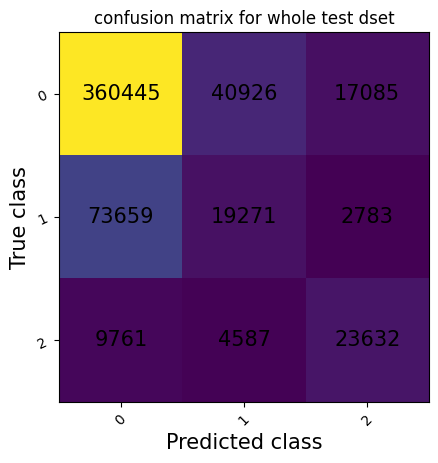

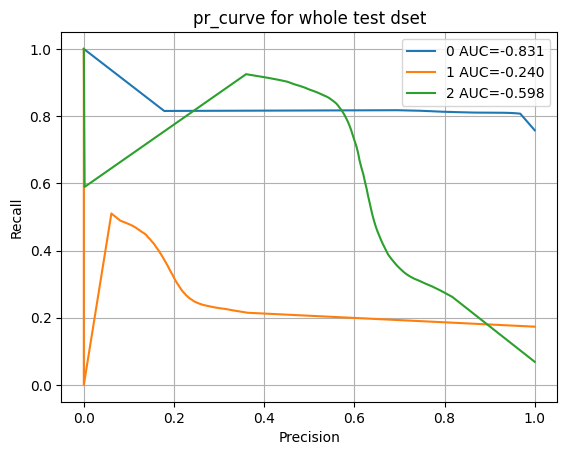

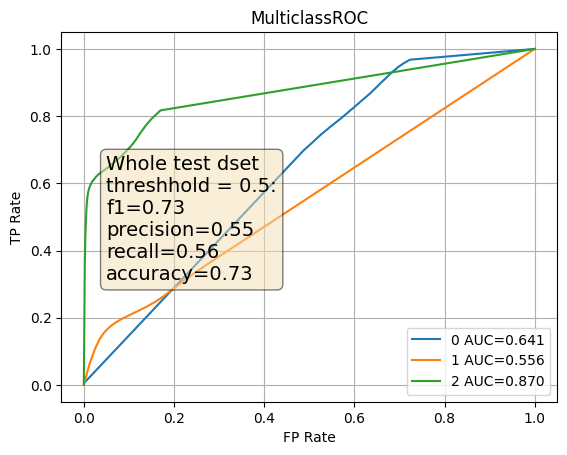

In [ ]:
metrics = am.test_model(f'{path}/runs/{timestamp}', model, test_dataloader, comment ='3 classes', signal_name=signal_name, writer=writer)

In [ ]:
am.per_shot_test(f'{path}/runs/{timestamp}', shots_for_testing, metrics[0], writer=writer)

  0%|          | 0/12 [00:00<?, ?it/s]

/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/torchmetrics/utilities/plot.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=rows, ncols=cols) if ax is None else (ax.get_figure(), ax)


'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/24-02-22, 17-42-46 InceptionTime on h_alpha/data'